# Base loads

In [1]:
!pip install pyro-ppl==1.3.0

     |████████████████████████████████| 501kB 3.5MB/s 


In [2]:
!nvidia-smi

Sun Jun 14 13:17:56 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8    29W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# "Standard" imports
import numpy as np
from time import time
import itertools
import matplotlib.pyplot as plt
import pickle
import os
import pandas as pd
import folium
import datetime

# Pytorch imports
import torch
import torch.nn.functional as F
from torch import nn
from torch import optim
from torch.utils.data import DataLoader

# Pyro imports
import pyro
from pyro.distributions import ConditionalTransformedDistribution, ConditionalTransformModule, TransformModule
import pyro.distributions as dist
from pyro.distributions.transforms import affine_coupling, affine_autoregressive, permute

# Sklearn imports
from sklearn import datasets
from sklearn.preprocessing import StandardScaler

# Notebooks imports
from IPython.display import Image, display, clear_output
from tqdm import tqdm
from ipywidgets import interact, interactive, fixed, interact_manual


import numpy as np
import folium
from folium import plugins
import matplotlib
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
from google.colab import drive
import sys
import os
drive.mount('/content/drive/')
root_path = 'drive/My Drive/Colab_Notebooks/normalizingflows'
trained_flows_folder = 'drive/My Drive/Colab_Notebooks/normalizingflows/trained_flows'
dataset_folder = 'drive/My Drive/Colab_Notebooks/normalizingflows/datasets'
sys.path.append(root_path)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


## Load Git code

In [5]:
%cd drive/'My Drive'/Thesis/code/DEwNF/
!git pull
%cd /content/

/content/drive/My Drive/Thesis/code/DEwNF
Already up to date.
/content


In [0]:
git_folder_path = 'drive/My Drive/Thesis/code/DEwNF/'
sys.path.append(git_folder_path)

In [0]:
from DEwNF.flows import ConditionalAffineCoupling, ConditionedAffineCoupling, ConditionalNormalizingFlowWrapper, conditional_affine_coupling, normalizing_flow_factory, conditional_normalizing_flow_factory
from DEwNF.utils import plot_4_contexts_cond_flow, plot_loss, sliding_plot_loss, plot_samples
from DEwNF.samplers import RotatingTwoMoonsConditionalSampler
from DEwNF.regularizers import NoiseRegularizer, rule_of_thumb_noise_schedule, approx_rule_of_thumb_noise_schedule, square_root_noise_schedule, constant_regularization_schedule


# Batchnorm and different regularizations two moons with 2d context

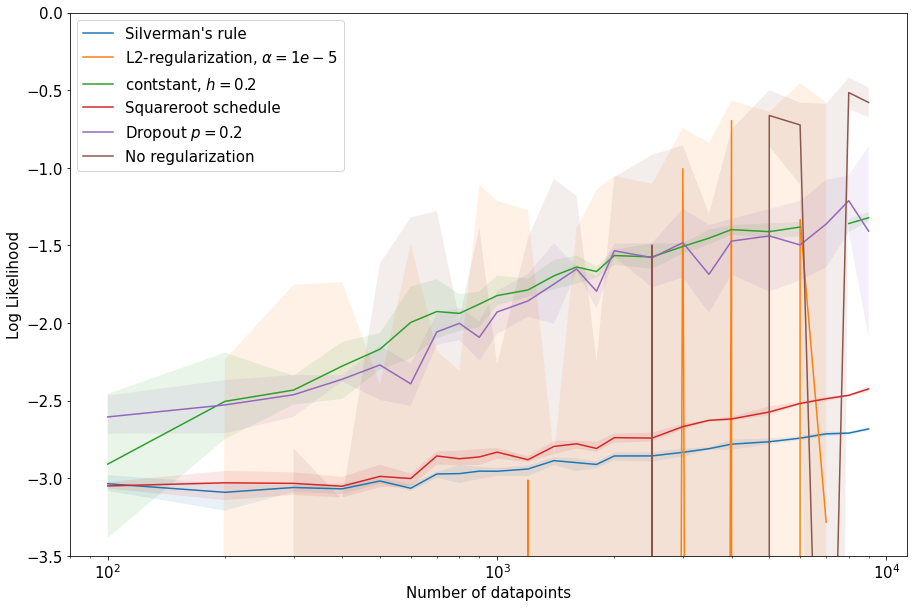

In [9]:
base_path = os.path.join(root_path, "results/two_moons/reg_run1")

results_dict = {}

folders = os.listdir(base_path)
for run_name in folders:
    run_path = folder = os.path.join(base_path, run_name)
    reg_names = os.listdir(run_path)
    results_dict[run_name] = {}
    for reg_name in reg_names:
        reg_path = os.path.join(run_path, reg_name)
        file_names = os.listdir(reg_path)
        results_dict[run_name][reg_name] = {}
        for file_name in file_names:
            data_size = int(file_name.split('_')[-1].split('.')[0])
            file = os.path.join(reg_path, file_name)
            with open(file, 'rb') as f:
                loaded_dict = pickle.load(f)
            results_dict[run_name][reg_name][data_size] = loaded_dict['logs']['test'][-1]

runs = list(results_dict.keys())
#runs =['reg_comparisons1', 'reg_comparisons2', 'reg_comparisons6']
regs = list(results_dict[runs[0]].keys())
#regs = ['sqrt', 'l2', 'constant', 'rot']
data_sizes = np.sort(list(results_dict[runs[0]][regs[0]].keys()))

plot_arrays = {}
for reg in regs:
    reg_mean_array = []
    reg_max_array = []
    reg_min_array = []
    plot_arrays[reg] = {}
    for data_size in data_sizes:
        runs_array = []
        for run in runs:
            runs_array.append(results_dict[run][reg][data_size])
        reg_mean_array.append(np.mean(runs_array))
        reg_max_array.append(np.max(runs_array))
        reg_min_array.append(np.min(runs_array))
    plot_arrays[reg]['mean'] = reg_mean_array
    plot_arrays[reg]['max'] = reg_max_array
    plot_arrays[reg]['min'] = reg_min_array


plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(15,10))
plt.ylim(-3.5, 0)
#regs = ['batchnorm_and_clipped_adam']
#regs = ['base_flow']
#regs = ['batchnorm']
#regs = ['clipped_adam']
for reg in regs:
    mean = -np.array(plot_arrays[reg]['mean'])
    max_val = -np.array(plot_arrays[reg]['max'])
    min_val = -np.array(plot_arrays[reg]['min'])
    plt.plot(data_sizes, mean)
    plt.fill_between(data_sizes, max_val, min_val, alpha=0.1)

regs = ["Silverman's rule", r"L2-regularization, $\alpha=1e-5$", r"contstant, $h=0.2$", "Squareroot schedule", r"Dropout $p=0.2$", "No regularization"]
plt.xscale('log')
plt.legend(regs, loc='upper left', fontsize=15, markerscale=4)
plt.xlabel('Number of datapoints', fontsize=15)
plt.ylabel('Log Likelihood')
plt.show();


 
            

# Batchnorm and different regularizations on two moons with 4d context

In [0]:
base_path = os.path.join(root_path, "results/two_moons/long_run1")
results_dict = {}

folders = os.listdir(base_path)
for run_name in folders:
    run_path = folder = os.path.join(base_path, run_name)
    reg_names = os.listdir(run_path)
    results_dict[run_name] = {}
    for reg_name in reg_names:
        reg_path = os.path.join(run_path, reg_name)
        file_names = os.listdir(reg_path)
        results_dict[run_name][reg_name] = {}
        for file_name in file_names:
            data_size = int(file_name.split('_')[-1].split('.')[0])
            file = os.path.join(reg_path, file_name)
            with open(file, 'rb') as f:
                loaded_dict = pickle.load(f)
            results_dict[run_name][reg_name][data_size] = loaded_dict['logs']['test'][-1]

runs = list(results_dict.keys())
#runs = ['long_run2']
regs = list(results_dict[runs[0]].keys())
#regs = ['constant', 'no_reg']
data_sizes = np.sort(list(results_dict[runs[0]][regs[0]].keys()))
            
plot_arrays = {}
for reg in regs:
    reg_mean_array = []
    reg_max_array = []
    reg_min_array = []
    plot_arrays[reg] = {}
    for data_size in data_sizes:
        runs_array = []
        for run in runs:
            runs_array.append(results_dict[run][reg][data_size])
        reg_mean_array.append(np.mean(runs_array))
        reg_max_array.append(np.max(runs_array))
        reg_min_array.append(np.min(runs_array))
    plot_arrays[reg]['mean'] = reg_mean_array
    plot_arrays[reg]['max'] = reg_max_array
    plot_arrays[reg]['min'] = reg_min_array


plt.figure(figsize=(15,10))
plt.ylim(-3.5, 1)
#regs = ['batchnorm_and_clipped_adam']
#regs = ['base_flow']
#regs = ['batchnorm']
#regs = ['clipped_adam']
for reg in regs:
    mean = -np.array(plot_arrays[reg]['mean'])
    max_val = -np.array(plot_arrays[reg]['max'])
    min_val = -np.array(plot_arrays[reg]['min'])
    plt.plot(data_sizes, mean)
    plt.fill_between(data_sizes, max_val, min_val, alpha=0.1)

plt.xscale('log')
plt.legend(regs, loc='upper left', fontsize=15, markerscale=4)
plt.title('1500 epochs and 500 batchsize ', fontsize=15)
plt.xlabel('Number of datapoints', fontsize=15)
plt.ylabel('Log Likelihood')
plt.show();


KeyError: ignored

# Comparison of different noise regularization on two moons with 4d context


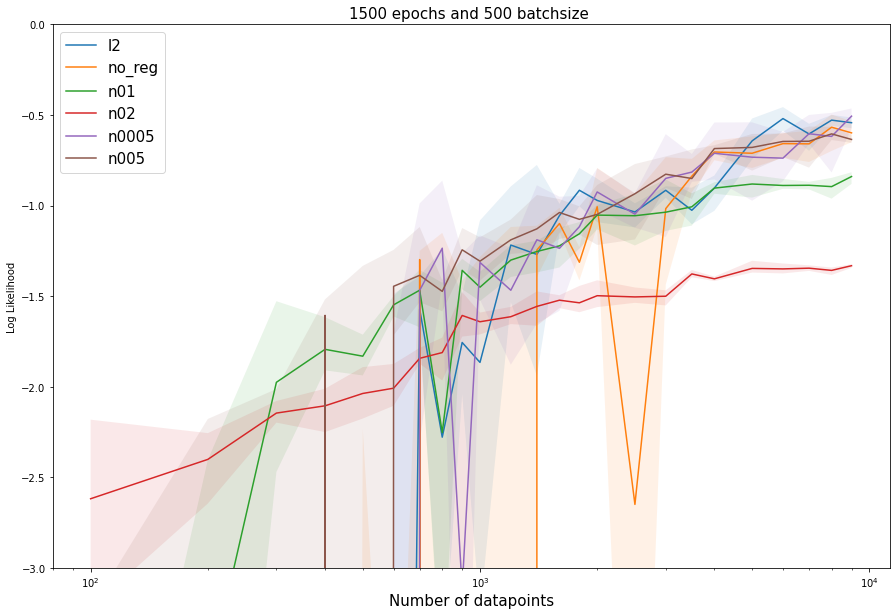

In [0]:
base_path = os.path.join(root_path, "results/two_moons/reg_run_noise_comp")
results_dict = {}

folders = os.listdir(base_path)
for run_name in folders:
    run_path = folder = os.path.join(base_path, run_name)
    reg_names = os.listdir(run_path)
    results_dict[run_name] = {}
    for reg_name in reg_names:
        reg_path = os.path.join(run_path, reg_name)
        file_names = os.listdir(reg_path)
        results_dict[run_name][reg_name] = {}
        for file_name in file_names:
            data_size = int(file_name.split('_')[-1].split('.')[0])
            file = os.path.join(reg_path, file_name)
            with open(file, 'rb') as f:
                loaded_dict = pickle.load(f)
            results_dict[run_name][reg_name][data_size] = loaded_dict['logs']['test'][-1]

runs = list(results_dict.keys())
#runs = ['long_run2']
regs = list(results_dict[runs[0]].keys())
#regs = ['constant', 'no_reg']
data_sizes = np.sort(list(results_dict[runs[0]][regs[0]].keys()))
            
plot_arrays = {}
for reg in regs:
    reg_mean_array = []
    reg_max_array = []
    reg_min_array = []
    plot_arrays[reg] = {}
    for data_size in data_sizes:
        runs_array = []
        for run in runs:
            runs_array.append(results_dict[run][reg][data_size])
        reg_mean_array.append(np.mean(runs_array))
        reg_max_array.append(np.max(runs_array))
        reg_min_array.append(np.min(runs_array))
    plot_arrays[reg]['mean'] = reg_mean_array
    plot_arrays[reg]['max'] = reg_max_array
    plot_arrays[reg]['min'] = reg_min_array


plt.figure(figsize=(15,10))
plt.ylim(-3, 0)
#regs = ['batchnorm_and_clipped_adam']
#regs = ['base_flow']
#regs = ['batchnorm']
#regs = ['clipped_adam']
for reg in regs:
    mean = -np.array(plot_arrays[reg]['mean'])
    max_val = -np.array(plot_arrays[reg]['max'])
    min_val = -np.array(plot_arrays[reg]['min'])
    plt.plot(data_sizes, mean)
    plt.fill_between(data_sizes, max_val, min_val, alpha=0.1)

plt.xscale('log')
plt.legend(regs, loc='upper left', fontsize=15, markerscale=4)
plt.title('1500 epochs and 500 batchsize ', fontsize=15)
plt.xlabel('Number of datapoints', fontsize=15)
plt.ylabel('Log Likelihood')
plt.show();

